## DATA 512- Part 1- Common Analysis
by Vritesh Gera

This work is inspired by the project which we were assigned to work on in DATA 512. This is the Part 1 of the analysis on wildfires and how the smoke from wildfires effect the cities near them. I have been assigned Klanath Falls, Ogeon. Th main inspiration behind this project is that more frequently summers in the western US have been characterized by wildfires with smoke billowing across multiple western states. There are many proposed causes for this: climate change, US Forestry policy, growing awareness, just to name a few. Regardless of the cause, the impact of wildland fires is widespread.

To start our analysis, we would first download the needed python libraries. 

In [7]:
#    IMPORTS
#    Import some standard python modules
import os, json, time
#
#    The module pyproj is a standard module that can be installed using pip. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
#
#    The 'wildfire' module is a user module. This module is available from the course website. The module
#    includes one object, a Reader, that can be used to read the GeoJSON files associated with the
#    wildefire dataset. The module also contains a sample datafile that is GeoJSON compliant and that
#    contains a small number of California wildfires extracted from the main wildfire dataset.
#    
from Reader import Reader as WFReader
#
#    There is a GeoJSON reader that you might try if you wanted to read the data. It has its own quirks.
#    There will be an example below that reads the sample file "Wildfire_short_sample.json"
#    
import geojson
import pandas as pd
from tqdm import tqdm

Now we will declare the city on which we will be working on and its latitude and longitude. The city which I got assigned was Klamath Falls, Oregon.

In [8]:
#Constant with the city name and latitude-longitude 
CITY_LOCATIONS = {
    'klamath' :     {'city'   : 'Klamath Falls',
                     'latlon' : [42.224869, -121.781670] }
}

In [9]:
#Here we define the name of the JSON which has the wildfire data for the whole USA. This file has been downloaded to our local system.
EXTRACT_FILENAME = "USGS_Wildland_Fire_Combined_Dataset.json"

In [10]:
#In the next part, we will be using the Reader which has been attached to this repository and is being provided to us by Professor David W. McDonald     
#This bit of code opens a new wildfire reader, gets the header information and prints it to the screen
#
print(f"Attempting to open '{EXTRACT_FILENAME}' with wildfire.Reader() object")
wfreader = WFReader(EXTRACT_FILENAME)
print()
#
#    Now we will print the header - it contains some useful information
#
header_dict = wfreader.header()
header_keys = list(header_dict.keys())
print("The header has the following keys:")
print(header_keys)
print()
print("Header Dictionary")
print(json.dumps(header_dict,indent=4))


Attempting to open 'USGS_Wildland_Fire_Combined_Dataset.json' with wildfire.Reader() object

The header has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields']

Header Dictionary
{
    "displayFieldName": "",
    "fieldAliases": {
        "OBJECTID": "OBJECTID",
        "USGS_Assigned_ID": "USGS Assigned ID",
        "Assigned_Fire_Type": "Assigned Fire Type",
        "Fire_Year": "Fire Year",
        "Fire_Polygon_Tier": "Fire Polygon Tier",
        "Fire_Attribute_Tiers": "Fire Attribute Tiers",
        "GIS_Acres": "GIS_Acres",
        "GIS_Hectares": "GIS_Hectares",
        "Source_Datasets": "Source Datasets",
        "Listed_Fire_Types": "Listed Fire Types",
        "Listed_Fire_Names": "Listed Fire Names",
        "Listed_Fire_Codes": "Listed Fire Codes",
        "Listed_Fire_IDs": "Listed Fire IDs",
        "Listed_Fire_IRWIN_IDs": "Listed Fire IRWIN IDs",
        "Listed_Fire_Dates": "Listed Fire Dates",
        "Listed_Fire_C

Now as we have tested the file on a single header, we will read in all the features into a list

In [11]:
#This code will load the features of the whole file

feature_list = list()
feature_count = 0

# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result

wfreader.rewind()

# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 100) == 0:
        print(f"Loaded {feature_count} features")

    feature = wfreader.next()
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")

#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")




Loaded 100 features
Loaded 200 features
Loaded 300 features
Loaded 400 features
Loaded 500 features
Loaded 600 features
Loaded 700 features
Loaded 800 features
Loaded 900 features
Loaded 1000 features
Loaded 1100 features
Loaded 1200 features
Loaded 1300 features
Loaded 1400 features
Loaded 1500 features
Loaded 1600 features
Loaded 1700 features
Loaded 1800 features
Loaded 1900 features
Loaded 2000 features
Loaded 2100 features
Loaded 2200 features
Loaded 2300 features
Loaded 2400 features
Loaded 2500 features
Loaded 2600 features
Loaded 2700 features
Loaded 2800 features
Loaded 2900 features
Loaded 3000 features
Loaded 3100 features
Loaded 3200 features
Loaded 3300 features
Loaded 3400 features
Loaded 3500 features
Loaded 3600 features
Loaded 3700 features
Loaded 3800 features
Loaded 3900 features
Loaded 4000 features
Loaded 4100 features
Loaded 4200 features
Loaded 4300 features
Loaded 4400 features
Loaded 4500 features
Loaded 4600 features
Loaded 4700 features
Loaded 4800 features
L

# Distance computations with Pyproj

One issue in performing geodetic computation is that any (all) geographic coordinate systems are eventually translated to the surface of the earth - which is not flat. That means every computation of distance between two points is some kind of arc (not actually a straight line). Further the earth is not a true sphere, its a type of ellipsoid. That means the amount of curvature varies depending upon where you are on the surface and the direction - which changes the distance.

Lucky for us there are geographers who like to write code and have built systems to simplify the computation of distances over the earth's surface. One of those systems is called [Pyproj](https://pyproj4.github.io/pyproj/stable/index.html). It has functions that will convert coordinate points between (almost) any two of the many different geographic coordinate systems. As well, Pyproj provides ways to compute distances between two points (mostly assuming the points are already in the same coordinate system).

We will be using the Geod() object to calculate the distance between the selected city and the wildfires near it.

In [12]:
#First create a geodesic model that will be used for the calculations. There are a number of
#different models of the earth. The WSG84 is one that is commonly used and relatively up-to-date

geodcalc = Geod(ellps='WGS84')         # Use WGS84 ellipsoid representation of the earth


# Convert points between geodetic coordinate systems

One of the constraints in doing geodetic computations is that most of the time we need to have our points (the coordinates for places) in the same geographic coordinate system. There are tons and tons of coordinate systems. You can find descriptions of many of them at [EPSG.io](https://epsg.io).

Looking at the wildfire header information, you can find this in the output of Example 1, we can see fields named "geometryType" and "spatialReference". This looks like:

        "geometryType": "esriGeometryPolygon",
        "spatialReference": {
            "wkid": 102008,
            "latestWkid": 102008
        },

This indicates that the geometry of our wildfire data are generic polygons and that they are expressed in a coordinate system with the well-known ID (WKID) 102008. This coordinate system is also known as [ESRI:102008](https://epsg.io/102008)


That string, 'WGS84', is a representation of the earth, that also relies on a well known coordinate system that is sometimes called 'decimal degrees' (DD). That decimal degrees system has an official name (or WKID) of [EPSG:4326](https://epsg.io/4326).

For the exercise below, what we're going to do is take the geometry of a fire feature, extract the largest ring (i.e., the largest boundary of the fire) and convert all of the points in that ring from the ESRI:102008 coordinate system to EPSG:4326 coordinates.


In [13]:

#    Transform feature geometry data
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

# Compute distance between a place and a wildfire

The basic problem is knowing how far away a fire is from some location (like a city). One issue is that fires are irregularly shaped so the actual answer to that is a bit dependent upon the exact shape and how you want to think about the notion of 'distance'. For example, should we just find the closest point on the perimiter of a fire and call that the distance? Maybe we should find the centroid of the region, identify that as a geolocation (coordinate) and then calculate the distance to that? We can come up with numerous other ways.

The first bit of code finds the point on the perimiter with the shortest distance to the city (place) and returns the distance as well as the lat,lon of the perimeter point.

The second bit of code calculates the average distance of all perimeter points to the city (place) and returns that average as the distance. This is not quite what the centroid would be, but it is probably fairly close.

These are two reasonable ways to think about possible distance to a fire. But both require computing distance to a whole set of points on the perimeter of a fire.


In [14]:
#
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point



#
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average



# Filtering data of our city
Now we will filter data from the bigger dataset for our city and also pick the relevant columns which will be used for the smoke analysis.

In [15]:
from tqdm import tqdm
res = []
place = CITY_LOCATIONS["klamath"]
for wf_feature in tqdm(feature_list):
    try:
        wf_year = wf_feature['attributes']['Fire_Year']
        wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
        wf_size = wf_feature['attributes']['GIS_Acres']
        wf_type = wf_feature['attributes']['Assigned_Fire_Type']
        ring_data = wf_feature['geometry']['rings'][0]
    except:
        print("Attribute value missing")
    if 'rings' in wf_feature['geometry']:
        distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
        if distance <= 1250 and wf_year >= 1963:
            wf_feature['attributes']['distance'] = distance
            res.append(wf_feature['attributes'])

 81%|████████  | 109607/135061 [50:58<27:38, 15.35it/s]  

Attribute value missing


 82%|████████▏ | 110230/135061 [51:20<10:59, 37.63it/s]

Attribute value missing


 82%|████████▏ | 110645/135061 [51:30<10:22, 39.20it/s]

Attribute value missing


 83%|████████▎ | 111440/135061 [51:51<09:15, 42.55it/s]

Attribute value missing


 83%|████████▎ | 111780/135061 [51:59<09:40, 40.13it/s]

Attribute value missing


 83%|████████▎ | 111900/135061 [52:03<13:40, 28.22it/s]

Attribute value missing


 83%|████████▎ | 112417/135061 [52:21<10:22, 36.37it/s]

Attribute value missing
Attribute value missing


 84%|████████▍ | 113415/135061 [52:48<09:21, 38.58it/s]

Attribute value missing


 84%|████████▍ | 113671/135061 [52:56<09:43, 36.64it/s]

Attribute value missing


 84%|████████▍ | 113741/135061 [52:58<14:01, 25.34it/s]

Attribute value missing


 84%|████████▍ | 113770/135061 [53:00<23:17, 15.23it/s]

Attribute value missing


 84%|████████▍ | 113807/135061 [53:03<21:07, 16.77it/s]

Attribute value missing


 85%|████████▍ | 114312/135061 [53:35<20:07, 17.19it/s]

Attribute value missing


 85%|████████▍ | 114325/135061 [53:36<20:46, 16.64it/s]

Attribute value missing


 86%|████████▌ | 115632/135061 [55:03<20:09, 16.06it/s]

Attribute value missing


 86%|████████▌ | 115975/135061 [55:26<17:07, 18.57it/s]

Attribute value missing


 86%|████████▌ | 116238/135061 [55:44<19:08, 16.39it/s]

Attribute value missing


 87%|████████▋ | 117088/135061 [56:47<19:20, 15.49it/s]

Attribute value missing


 89%|████████▊ | 119585/135061 [59:37<15:49, 16.29it/s]

Attribute value missing


 89%|████████▊ | 119620/135061 [59:39<15:21, 16.76it/s]

Attribute value missing


 89%|████████▊ | 119755/135061 [59:49<15:17, 16.68it/s]

Attribute value missing


 89%|████████▉ | 119984/135061 [1:00:04<14:11, 17.70it/s]

Attribute value missing


 89%|████████▉ | 120215/135061 [1:00:19<15:06, 16.38it/s]

Attribute value missing


 89%|████████▉ | 120434/135061 [1:00:34<14:22, 16.96it/s]

Attribute value missing


 89%|████████▉ | 120681/135061 [1:00:50<15:06, 15.87it/s]

Attribute value missing


 89%|████████▉ | 120746/135061 [1:00:55<15:15, 15.64it/s]

Attribute value missing


 90%|████████▉ | 121013/135061 [1:01:13<14:52, 15.74it/s]

Attribute value missing


 91%|█████████ | 122266/135061 [1:02:35<13:00, 16.38it/s]

Attribute value missing


 91%|█████████ | 122533/135061 [1:02:53<12:07, 17.22it/s]

Attribute value missing


 92%|█████████▏| 123764/135061 [1:04:15<11:10, 16.86it/s]

Attribute value missing


 92%|█████████▏| 124539/135061 [1:05:07<10:43, 16.36it/s]

Attribute value missing


 93%|█████████▎| 125048/135061 [1:05:41<09:18, 17.93it/s]

Attribute value missing


 93%|█████████▎| 125749/135061 [1:06:30<09:32, 16.26it/s]

Attribute value missing


 94%|█████████▍| 127499/135061 [1:07:41<03:19, 37.82it/s]

Attribute value missing


100%|██████████| 135061/135061 [1:10:59<00:00, 31.71it/s]


This filtering and extraction took over an hour to complete. In order for me to not loose it, I will download it into my local system using the json.dump method.

In [18]:
import json
# Specify the file path where you want to save the JSON data
file_path = "wildfires_klamath_falls.json"
#res = []
# Open the file in write mode and save the data as JSON
with open(file_path, 'w') as json_file:
    json.dump(res, json_file)

I have written the below line of code just in case my session expires and I loose my data. I can read the data from my local system.

In [20]:
# Open the file in read mode and load the JSON data back into a list of dictionaries
with open(file_path, 'r') as json_file:
    loaded_data = json.load(json_file)

print(len(loaded_data))

75413


## Developing a Smoke Estimation Model

After a thorough analysis of the recorded fire attributes, it is evident that we can construct a reliable smoke estimation model by considering three key attributes:

1. **GIS_Hectares**: This attribute represents the calculated area of the fire polygon, determined using the Calculate Geometry tool in ArcGIS Pro.

2. **Distance**: It signifies the average distance in miles from the fire boundary to Lewiston, Idaho.

3. **Assigned_Fire_Type**: This attribute assumes five distinct values, each of which provides insights into the nature of the fire:

   a. **Likely Wildfire**: This category indicates that the fire is presumed to be a wildfire, although confirmation is lacking.
   
   b. **Wildfire**: Fires falling into this category are confirmed as wildfires based on available attributes.
   
   c. **Prescribed Wildfire**: Here, the fire is a confirmed prescribed fire based on the available attributes.
   
   d. **Unknown - Likely Wildfire**: These polygons, derived from MTBS, were initially labeled as "Unknown." However, research conducted by Karen Short suggests that they are likely wildfires.
   
   e. **Unknown - Likely Prescribed Wildfire**: Similar to the previous category, these polygons originated from MTBS and were marked as "Unknown." Yet, research by Karen Short suggests they are likely prescribed fires.

The use of the term "likely" within the attribute value also accounts for scenarios where a fire may not have occurred at all. However, when the attribute values are "Prescribed Wildfire" and "Wildfire," we can have a higher level of confidence in the occurrence of the fire.

To enhance the accuracy of our smoke estimation, we propose assigning weight factors based on the certainty of a fire occurrence:

1. **Likely Wildfire**: Weight factor of 15.

2. **Wildfire**: Weight factor of 20.

3. **Prescribed Wildfire**: Weight factor of 12.5.

4. **Unknown - Likely Wildfire**: Weight factor of 20.

5. **Unknown - Likely Prescribed Wildfire**: Weight factor of 12.5.

Now, to calculate the smoke estimate, we apply the following formula:

**smoke_estimate = (GIS_Hectares / distance) * Assigned_Fire_Type_Code**

This model accounts for both the spatial extent of the fire and the type of fire, with adjusted weight factors, to provide a more accurate smoke estimation.

Now I will assign the values which we have discussed above to some constants and calculate the smoke estimate for the data which I had extracted in the previous steps.

In [113]:
#Declarng a variable which takes in the data from the previous step
smoke_list = res
assigned_fire_type_weights = {
    'Likely Wildfire': 15,
    'Wildfire': 20,
    'Prescribed Wildfire': 12.5,
    'Unknown - Likely Wildfire': 20,
    'Unknown - Likely Prescribed Wildfire': 12.5
}
for wf_feature in tqdm(smoke_list):
    try:
        type_weight = wf_feature['Assigned_Fire_Type']
        fire_area = wf_feature['GIS_Hectares']/258.998811 #to convert the area to miles^2 
        fire_distance = wf_feature['distance']
    except:
        print("There is a missing attribute")
    if 'Assigned_Fire_Type' in wf_feature:
        if type_weight in assigned_fire_type_weights:
            smoke_estimate = (fire_area/fire_distance) * assigned_fire_type_weights[type_weight]
        else:
            smoke_estimate = fire_area/fire_distance
        wf_feature['smoke_estimate'] = smoke_estimate

100%|██████████| 75413/75413 [00:00<00:00, 693602.75it/s]


In [114]:
# We will extract the features that are required for our analysis and save it in a list: res_temp
import pandas as pd
res_temp = []
for wf_feature in tqdm(smoke_list):
    temp_feature = {}
    temp_feature['USGS_Assigned_ID'] = wf_feature['USGS_Assigned_ID']
    temp_feature['Assigned_Fire_Type'] = wf_feature['Assigned_Fire_Type']
    temp_feature['Fire_Year'] = wf_feature['Fire_Year']
    temp_feature['GIS_Hectares'] = wf_feature['GIS_Hectares']
    temp_feature['Listed_Fire_Names'] = wf_feature['Listed_Fire_Names']
    temp_feature['distance'] = wf_feature['distance']
    temp_feature['smoke_estimate'] = wf_feature['smoke_estimate']
    res_temp.append(temp_feature)
    
# convert res_temp to a dataframe
df_temp = pd.DataFrame(res_temp)
df_temp.head()

  0%|          | 0/75413 [00:00<?, ?it/s]

100%|██████████| 75413/75413 [00:00<00:00, 824144.60it/s]


,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Hectares,Listed_Fire_Names,distance,smoke_estimate
0,14299,Wildfire,1963,16589.059302,RATTLESNAKE (4),296.615380,4.318772
1,14300,Wildfire,1963,10423.524591,"McChord Butte (2), No Fire Name Provided (1), ...",282.607062,2.848156
2,14301,Wildfire,1963,18424.208617,"WILLOW CREEK (16), EAST CRANE CREEK (4), Crane...",308.368284,4.613721
3,14302,Wildfire,1963,4206.711433,"SOUTH CANYON CREEK (4), No Fire Name Provided (1)",314.108248,1.034179
4,14303,Wildfire,1963,4040.221900,WEBB CREEK (4),302.905042,1.029985


In [115]:
#Now we will check out the various metrics which this new dataframe has
df_temp['smoke_estimate'].describe()

count    7.541300e+04
mean     1.693508e-01
std      1.735081e+00
min      5.439804e-10
25%      3.893203e-04
50%      2.435286e-03
75%      2.309268e-02
max      1.660150e+02
Name: smoke_estimate, dtype: float64

In [116]:
#Assigning this temperary data to the final dataset which will be used for further reflections
df_final = df_temp

After doing some hit and trial analysis, I was able to come to the conclusion that all the smoke estimates below 2 were making the model train in a way which was giving lower values priority i.e. it was increasing the skewness of the model. In order to fix that, I removed the smoke estimates which were below 2.

In [117]:

df_final = df_final[df_final['smoke_estimate'] > 2]

In [118]:
df_final = df_final.groupby("Fire_Year")["smoke_estimate"].mean()
df_final.head()

Fire_Year
1963    3.926883
1964    4.508538
1965    3.138808
1966    4.516185
1967    2.395096
Name: smoke_estimate, dtype: float64

We can see that the index is messed up. Hence we'll write the below line of code to fix that.

In [119]:
df_final = df_final.reset_index()

In [120]:
df_final 

,Fire_Year,smoke_estimate
0,1963,3.926883
1,1964,4.508538
2,1965,3.138808
3,1966,4.516185
4,1967,2.395096
5,1968,2.732704
6,1970,4.179578
7,1971,5.205373
8,1972,2.463890
9,1973,4.114896


Let us plot a graph which shows us the trend of the Smoke Estimate Over Time

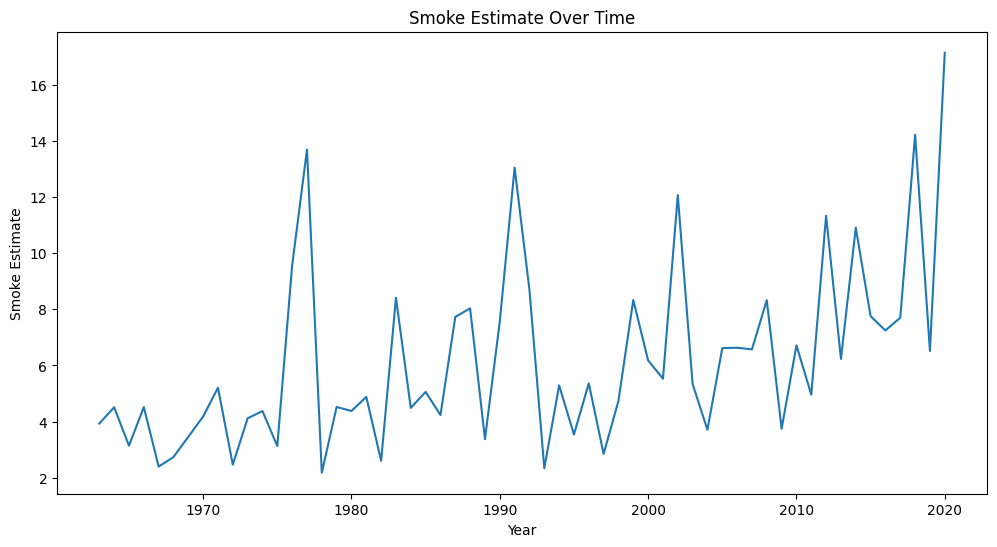

In [53]:
import matplotlib.pyplot as plt
df_final['Fire_Year'] = pd.to_datetime(df_final['Fire_Year'], format='%Y')
df_final.set_index('Fire_Year', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(df_final['smoke_estimate'])
plt.title('Smoke Estimate Over Time')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.show()


The graph seems to have a slight upward trend over the years. This was somehow expected as the number of wildfires which have been captured in the recent past are more vs the ones which were captured before due to limited technology. Also, the effect of global warming has also increased the number of wildfires.

## Time Series Forecasting

Now we will train our model. As the our data shows a very slight trend, we will try using the Auto Regresser. Autoregressive (AR) time series analysis is typically used when you suspect that the future values of a time series are linearly dependent on its past values. In other words, it's used when there is a temporal pattern or trend in the data, and you want to model and forecast future values based on their historical values.

In [56]:
# #We will use the stats model to import the AutoReg
# from statsmodels.tsa.ar_model import AutoReg
# # Fit the AutoReg model
# lag_order = 8  # We have decided an order of 8 so that the model considers the previous 8 instances to predict the next output
# model = AutoReg(data['smoke_estimate'], lags=lag_order)
# model_fit = model.fit()

# # Forecast future values
# forecast = model_fit.predict(start=len(data), end=len(data) + 25) 

c:\Users\vrite\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vrite\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\vrite\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\vrite\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, Datetime

In [57]:
#We will use the stats model to import the AutoReg
from statsmodels.tsa.ar_model import AutoReg
# Fit the AutoReg model
lag_order = 8  # We have decided an order of 8 so that the model considers the previous 8 instances to predict the next output
model = AutoReg(df_final['smoke_estimate'], lags=lag_order)
model_fit = model.fit()

# Forecast future values
forecast = model_fit.predict(start=0, end=len(df_final) + 25)  

c:\Users\vrite\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vrite\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\vrite\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\vrite\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, Datetime

In [61]:
#Here we will drop the NaNs from the forecast which are there due to the lag of 8
import math
forecast = [x for x in forecast if not math.isnan(x)]

In [62]:
#Converting the list of predictions into a dictionary with Years depicting the year for which the prediction is
predicted_values = {}
i=0
for year in range(1971, 2024):
    predicted_values[year] = forecast[i]
    i += 1
predicted_values

{1971: 4.245205764945516,
 1972: 5.346850355570302,
 1973: 4.651403116047995,
 1974: 4.999285483712193,
 1975: 4.083546794967823,
 1976: 6.595654723554792,
 1977: 6.218392767621923,
 1978: 5.836155082265143,
 1979: 7.424697761148391,
 1980: 5.212417446258058,
 1981: 4.7818830493988225,
 1982: 7.9742552202034656,
 1983: 5.461429833755956,
 1984: 8.093997646185684,
 1985: 4.888920148483116,
 1986: 6.824004536598072,
 1987: 4.381891216339929,
 1988: 8.00910385818696,
 1989: 4.48436638685336,
 1990: 8.422131898012305,
 1991: 6.727471165866943,
 1992: 7.0187425369853935,
 1993: 7.8956836405987065,
 1994: 7.103111500057379,
 1995: 5.988514841670114,
 1996: 6.639748248851777,
 1997: 6.942704339148253,
 1998: 6.09817811665962,
 1999: 8.038223647628852,
 2000: 4.2621089174046505,
 2001: 7.240446153585667,
 2002: 6.860742801274809,
 2003: 5.787892460286198,
 2004: 7.000158053118113,
 2005: 7.43519284728749,
 2006: 5.275801259687573,
 2007: 8.835980607931598,
 2008: 6.691306135452024,
 2009: 7.14

In [63]:
predicted_df = pd.DataFrame(list(predicted_values.items()), columns=['year', 'smoke_estimate'])
predicted_df['year'] = pd.to_datetime(predicted_df['year']).dt.year
predicted_df.head()

,year,smoke_estimate
0,1970,4.245206
1,1970,5.346850
2,1970,4.651403
3,1970,4.999285
4,1970,4.083547


## Fetching AQI data from US EPA

Now we have our predicted values ready which have been produced by taking into consideration the datapoints of the smoke estimate we calculated using our formula. Now we will compare this data with the data present in the AQI (Air Quality Index) data from the US EPA. The calling of the API and fetching of data was done in a seperate notebook epa_air_quality_history.ipynb which will be part of this Github repository. I have taken the dump of the AQI values from that notebook into my local system and will be reading that data into this notebook in the following step.

In [91]:
file_path = 'aqi_list.json'

# Read data from the JSON file
with open(file_path, 'r') as file:
    aqi_year = json.load(file)

In [92]:
aqi_year 

{'1986': 50.3448275862069,
 '1987': 59.648,
 '1988': 50.20477815699659,
 '1989': 53.70318021201413,
 '1990': 40.6643109540636,
 '1991': 30.574647887323945,
 '1992': 22.905525846702318,
 '1993': 23.923076923076923,
 '1994': 21.90277777777778,
 '1995': 16.06401384083045,
 '1996': 15.950998185117967,
 '1997': 15.516634050880626,
 '1998': 12.903966597077245,
 '1999': 35.35352006056018,
 '2000': 33.61462979482605,
 '2001': 31.311682242990653,
 '2002': 51.68303946263644,
 '2003': 31.87837837837838,
 '2004': 33.46728187919463,
 '2005': 35.48171206225681,
 '2006': 37.906463878326996,
 '2007': 35.853731343283584,
 '2008': 44.38488210818308,
 '2009': 35.667053364269144,
 '2010': 27.602144133412747,
 '2011': 34.247032640949556,
 '2012': 34.68377358490566,
 '2013': 40.892628205128204,
 '2014': 31.44768310911809,
 '2015': 36.14423076923077,
 '2016': 26.671152228763667,
 '2017': 38.21854304635762,
 '2018': 47.17062818336163,
 '2019': 32.510559360730596,
 '2020': 54.73062015503876,
 '2021': 51.047512

Now we will move on to some of the visualizations which the problem statement has asked us to make.

## Visualizations

Q1. Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.

In [87]:
dist_df = df_temp[['USGS_Assigned_ID', 'distance']]
dist_df.head()

,USGS_Assigned_ID,distance
0,14299,296.615380
1,14300,282.607062
2,14301,308.368284
292,14600,544.554349
293,14601,254.233492


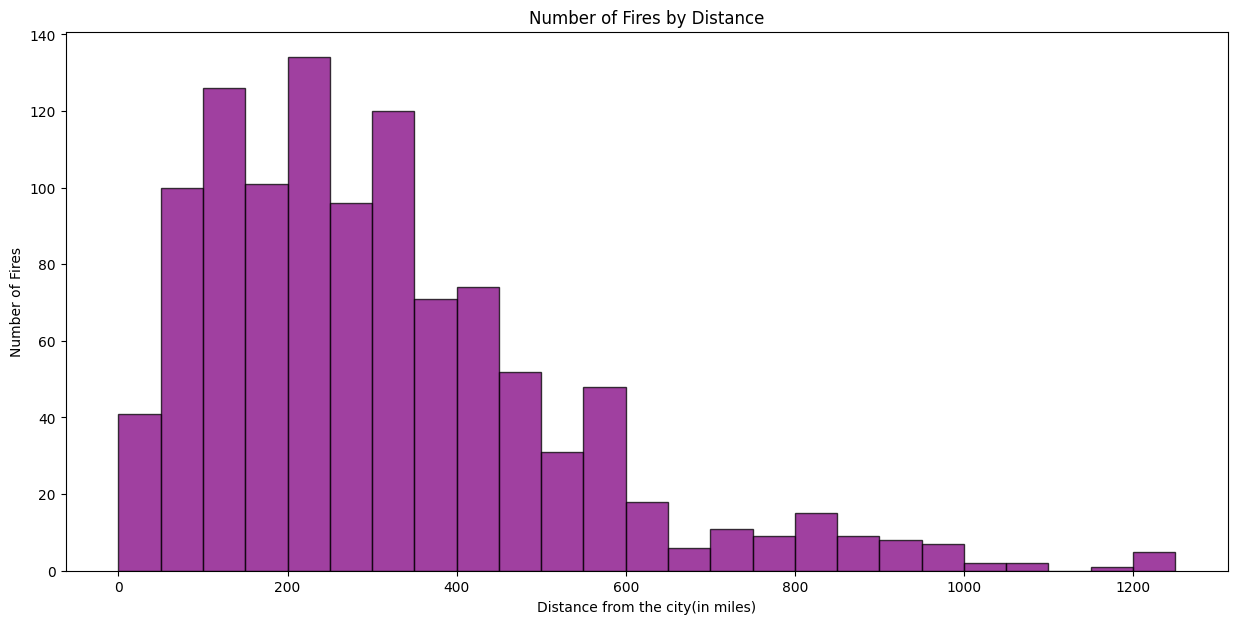

In [100]:
# Set the maximum specified distance as it is given in the problem
max_distance = 1250 

# Calculate the number of bins and their width
bin_width = 50
num_bins = int(max_distance / bin_width)
bins = [i * bin_width for i in range(num_bins + 1)]

# Create a histogram plot
plt.figure(figsize=(15, 7))
plt.hist(dist_df['distance'], bins=bins, edgecolor='k', alpha=0.75, color='purple')

# Set labels and title
plt.xlabel('Distance from the city(in miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires by Distance')

# Display the histogram
plt.show()


 Q2. Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.


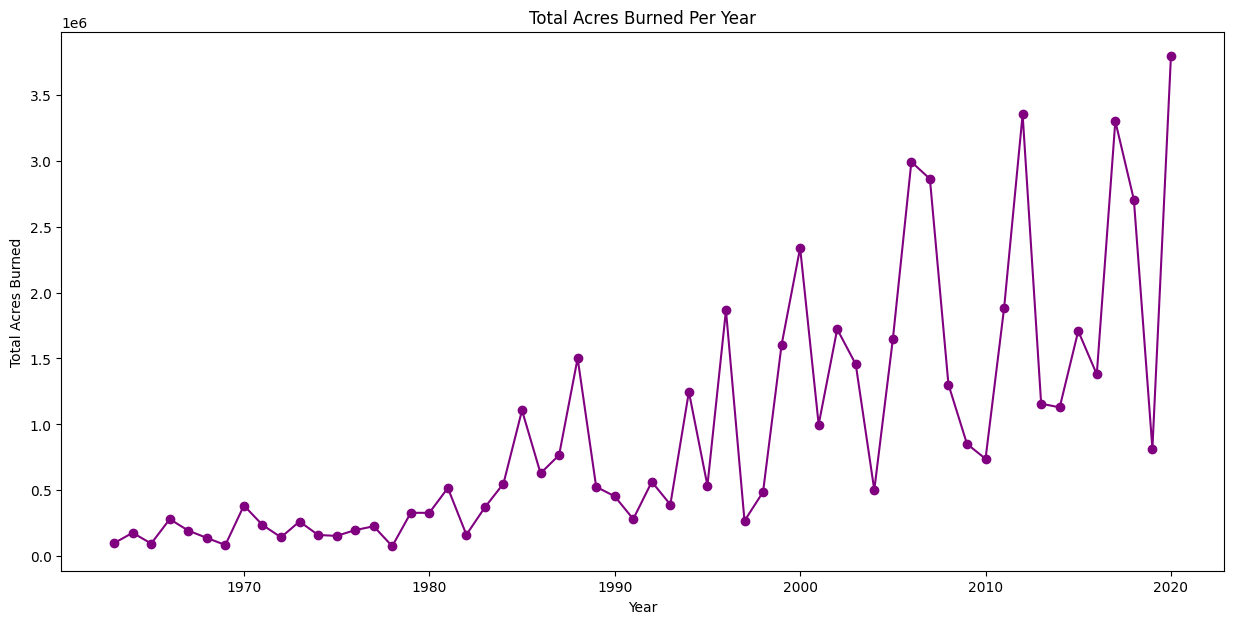

In [121]:
df_area = df_temp[['USGS_Assigned_ID', 'GIS_Hectares', 'Fire_Year']]

# Group and sum the total acres burned per year
total_acres_burned_per_year = df_area.groupby('Fire_Year')['GIS_Hectares'].sum()
plt.figure(figsize=(15,7))
# Create a time series graph
plt.plot(total_acres_burned_per_year.index, total_acres_burned_per_year.values, marker='o', linestyle='-',color='purple')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned Per Year')

# Show the graph
plt.show()

Q3. Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

In [122]:
#Here we will create a dataframe having our smoke estimate data
df_final_new = df_final.reset_index()
df_final_new['year'] = pd.to_datetime(df_final_new['Fire_Year']).dt.year
df_final_new.head()

,index,Fire_Year,smoke_estimate,year
0,0,1963,3.926883,1970
1,1,1964,4.508538,1970
2,2,1965,3.138808,1970
3,3,1966,4.516185,1970
4,4,1967,2.395096,1970


In [96]:
#In this part, we are converting our aqi data, which we extracted in the other notebook, into a dataframe for using it to create a graph
aqi_year_df = pd.DataFrame(list(aqi_year.items()), columns=['year', 'AQI'])
aqi_year_df['year'] = pd.to_datetime(aqi_year_df['year']).dt.year
aqi_year_df.head()

,year,AQI
0,1986,50.344828
1,1987,59.648000
2,1988,50.204778
3,1989,53.703180
4,1990,40.664311


In [97]:
#Here we will do an inner join so that the data for the common years is merged into a single dataframe 
merged_df = pd.merge(df_final_new, aqi_year_df, on='year', how='inner')
merged_df.head()

,Fire_Year,smoke_estimate,year,AQI
0,1986-01-01,4.231032,1986,50.344828
1,1987-01-01,7.728829,1987,59.648000
2,1988-01-01,8.033791,1988,50.204778
3,1989-01-01,3.372340,1989,53.703180
4,1990-01-01,7.569372,1990,40.664311


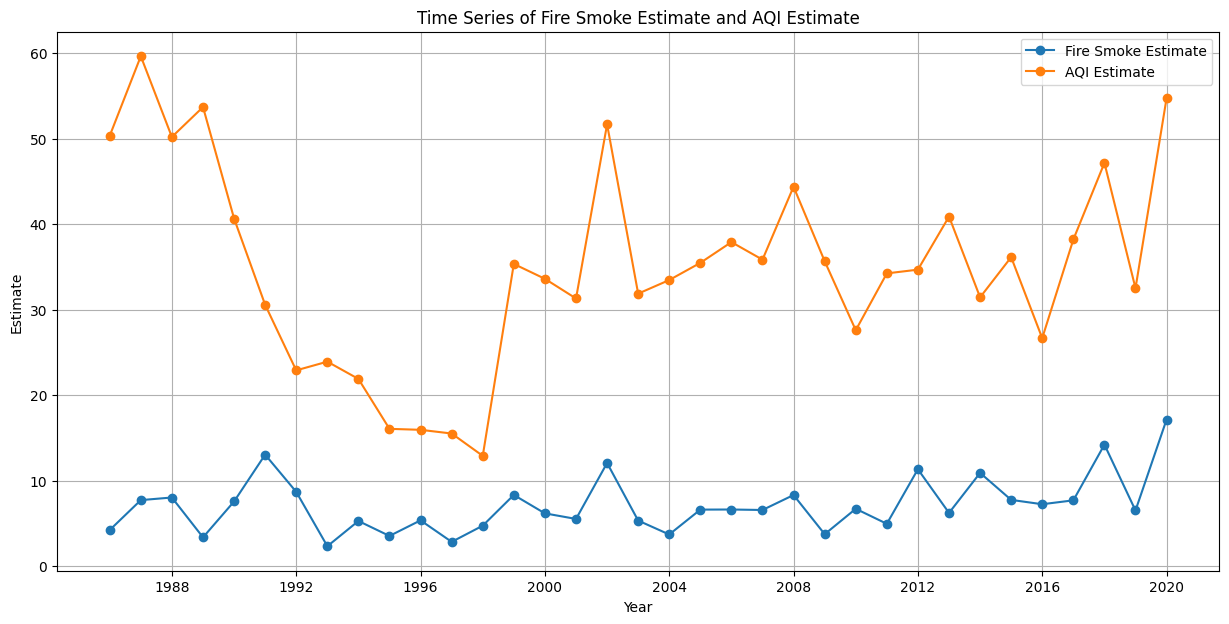

In [98]:
#Converting the fire year to a date time format 
merged_df['year'] = pd.to_datetime(merged_df['Fire_Year'])

# Create the time series graph
plt.figure(figsize=(15, 7))
plt.plot(merged_df['year'], merged_df['smoke_estimate'], label='Fire Smoke Estimate', marker='o', linestyle='-')
plt.plot(merged_df['year'], merged_df['AQI'], label='AQI Estimate', marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Estimate')
plt.title('Time Series of Fire Smoke Estimate and AQI Estimate')
plt.legend()

# Show the graph
plt.grid(True)
plt.show()